In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy.stats import skew

import optuna
import optuna.visualization as opt_vis
import shap

import joblib

pd.set_option("display.max_columns", None)
plt.style.use('ggplot')
filterwarnings('ignore')

In [52]:
train = pd.read_csv('../data/raw/Train.csv')
test = pd.read_csv('../data/raw/Test.csv')
submission = pd.read_csv('../data/raw/Submission.csv')
train.head()

,Site_Area,Structure_Type,Water_Consumption_Per_Building,Recycling_Rate,Utilization_Rate,Air_Quality_Index,Issue_Resolution_Time,Resident_Count,Electricity_Cost
0,Hebbal,Residential,1558.887420,38.143488,96.190774,60.329943,9.776145,333,15421.85624
1,Koramangala,Institutional,760.738916,30.365679,85.709589,29.613212,12.011880,306,22247.03278
2,Banashankari,Commercial,782.410030,33.219435,80.258544,60.630260,16.698976,482,19999.25905
3,Yelahanka,Commercial,536.149475,34.094487,74.981293,65.965449,20.128330,99,14641.76268
4,Malleshwaram,Commercial,544.149079,12.764772,94.415086,37.341041,1.564507,228,21492.92556


In [37]:
train.shape, test.shape, submission.shape

((11220, 9), (300, 9), (300, 1))

In [38]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['#Missing'] = df.isnull().sum()
    summ['%Missing'] = df.isnull().sum() / df.shape[0] * 100
    summ['Nunique'] = df.nunique()

    return summ

summary(train)

,dtypes,#Missing,%Missing,Nunique
Site_Area,object,0,0.0,11
Structure_Type,object,0,0.0,4
Water_Consumption_Per_Building,float64,0,0.0,10001
Recycling_Rate,float64,0,0.0,11220
Utilization_Rate,float64,0,0.0,10426
Air_Quality_Index,float64,0,0.0,11220
Issue_Resolution_Time,float64,0,0.0,11220
Resident_Count,int64,0,0.0,649
Electricity_Cost,float64,0,0.0,11220


In [5]:
summary(test)

,dtypes,#Missing,%Missing,Nunique
Site_Area,object,0,0.0,11
Structure_Type,object,0,0.0,4
Water_Consumption_Per_Building,float64,0,0.0,280
Recycling_Rate,float64,0,0.0,300
Utilization_Rate,float64,0,0.0,285
Air_Quality_Index,float64,0,0.0,300
Issue_Resolution_Time,float64,0,0.0,300
Resident_Count,int64,0,0.0,218
Electricity_Cost,float64,300,100.0,0


In [6]:
train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Site_Area,11220,11,Koramangala,1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Structure_Type,11220,4,Residential,2823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Consumption_Per_Building,11220.0,NaN,NaN,NaN,669.627346,442.334223,50.0,310.9261,645.350875,974.595698,2497.575182
Recycling_Rate,11220.0,NaN,NaN,NaN,30.424071,14.819558,0.013758,19.612979,30.022837,40.430728,92.115273
Utilization_Rate,11220.0,NaN,NaN,NaN,76.978462,14.360527,20.502148,67.192753,77.354007,87.83049,100.0
Air_Quality_Index,11220.0,NaN,NaN,NaN,47.913144,28.049396,0.058908,26.056544,45.228772,66.519578,162.748798
Issue_Resolution_Time,11220.0,NaN,NaN,NaN,10.888584,5.772868,1.003604,6.446922,10.360982,14.648047,37.726069
Resident_Count,11220.0,NaN,NaN,NaN,254.848396,137.276697,1.0,157.0,253.0,350.0,772.0
Electricity_Cost,11220.0,NaN,NaN,NaN,17766.972343,4462.29017,3946.936159,14678.697615,17752.676615,20721.172898,35983.96699


In [53]:
LABEL = 'Electricity_Cost'

In [54]:
print("Total Duplicates (train):", train.duplicated().sum())
print("Total Duplicates (test):", test.duplicated().sum())

Total Duplicates (train): 0
Total Duplicates (test): 0


In [55]:
categoric = train.select_dtypes(include=['object']).columns
numeric = [col for col in train.select_dtypes(include=['number']).columns if col != LABEL]

In [56]:
for col in categoric:
    print(f"Unique values in '{col}': {train[col].unique()}")

Unique values in 'Site_Area': ['Hebbal' 'Koramangala' 'Banashankari' 'Yelahanka' 'Malleshwaram'
 'BTM Layout' 'Indiranagar' 'Jayanagar' 'Electronic City' 'Whitefield'
 'HSR Layout']
Unique values in 'Structure_Type ': ['Residential' 'Institutional' 'Commercial' 'Industrial']


In [10]:
for col in categoric:
    print(train[col].value_counts())
    print()

Site_Area
Koramangala        1083
Hebbal             1057
Electronic City    1053
Jayanagar          1035
Banashankari       1031
Indiranagar        1024
Yelahanka          1014
HSR Layout         1007
Malleshwaram       1000
BTM Layout         1000
Whitefield          916
Name: count, dtype: int64

Structure_Type 
Residential      2823
Commercial       2823
Institutional    2789
Industrial       2785
Name: count, dtype: int64



In [17]:
for col in categoric:
    for v in train[col].unique():
        if v not in test[col].unique():
            print(f"Value '{v}' in column '{col}' is not present in test set.")

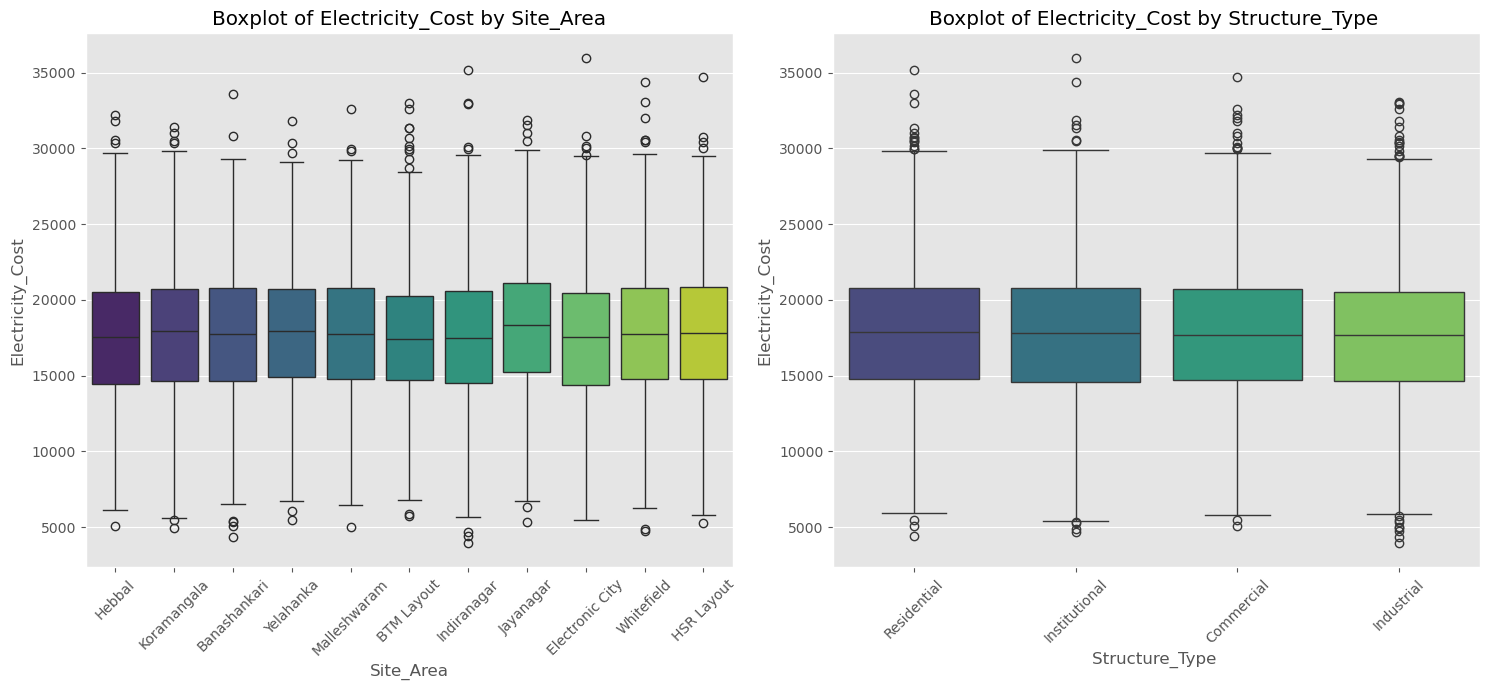

In [ ]:
def box_plot_label(cat, train):
    length = len(cat)
    cols = 2
    rows = length // cols + (length % cols > 0)

    plt.figure(figsize = (15, rows*cols+5))
    for i, col in enumerate(cat,1):
        plt.subplot(rows, cols, i)

        sns.boxplot(x = col, y = LABEL, data = train, palette='viridis')

        plt.title(f'Boxplot of {LABEL} by {col}')
        plt.xlabel(col)
        plt.ylabel(LABEL)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

box_plot_label(categoric, train)


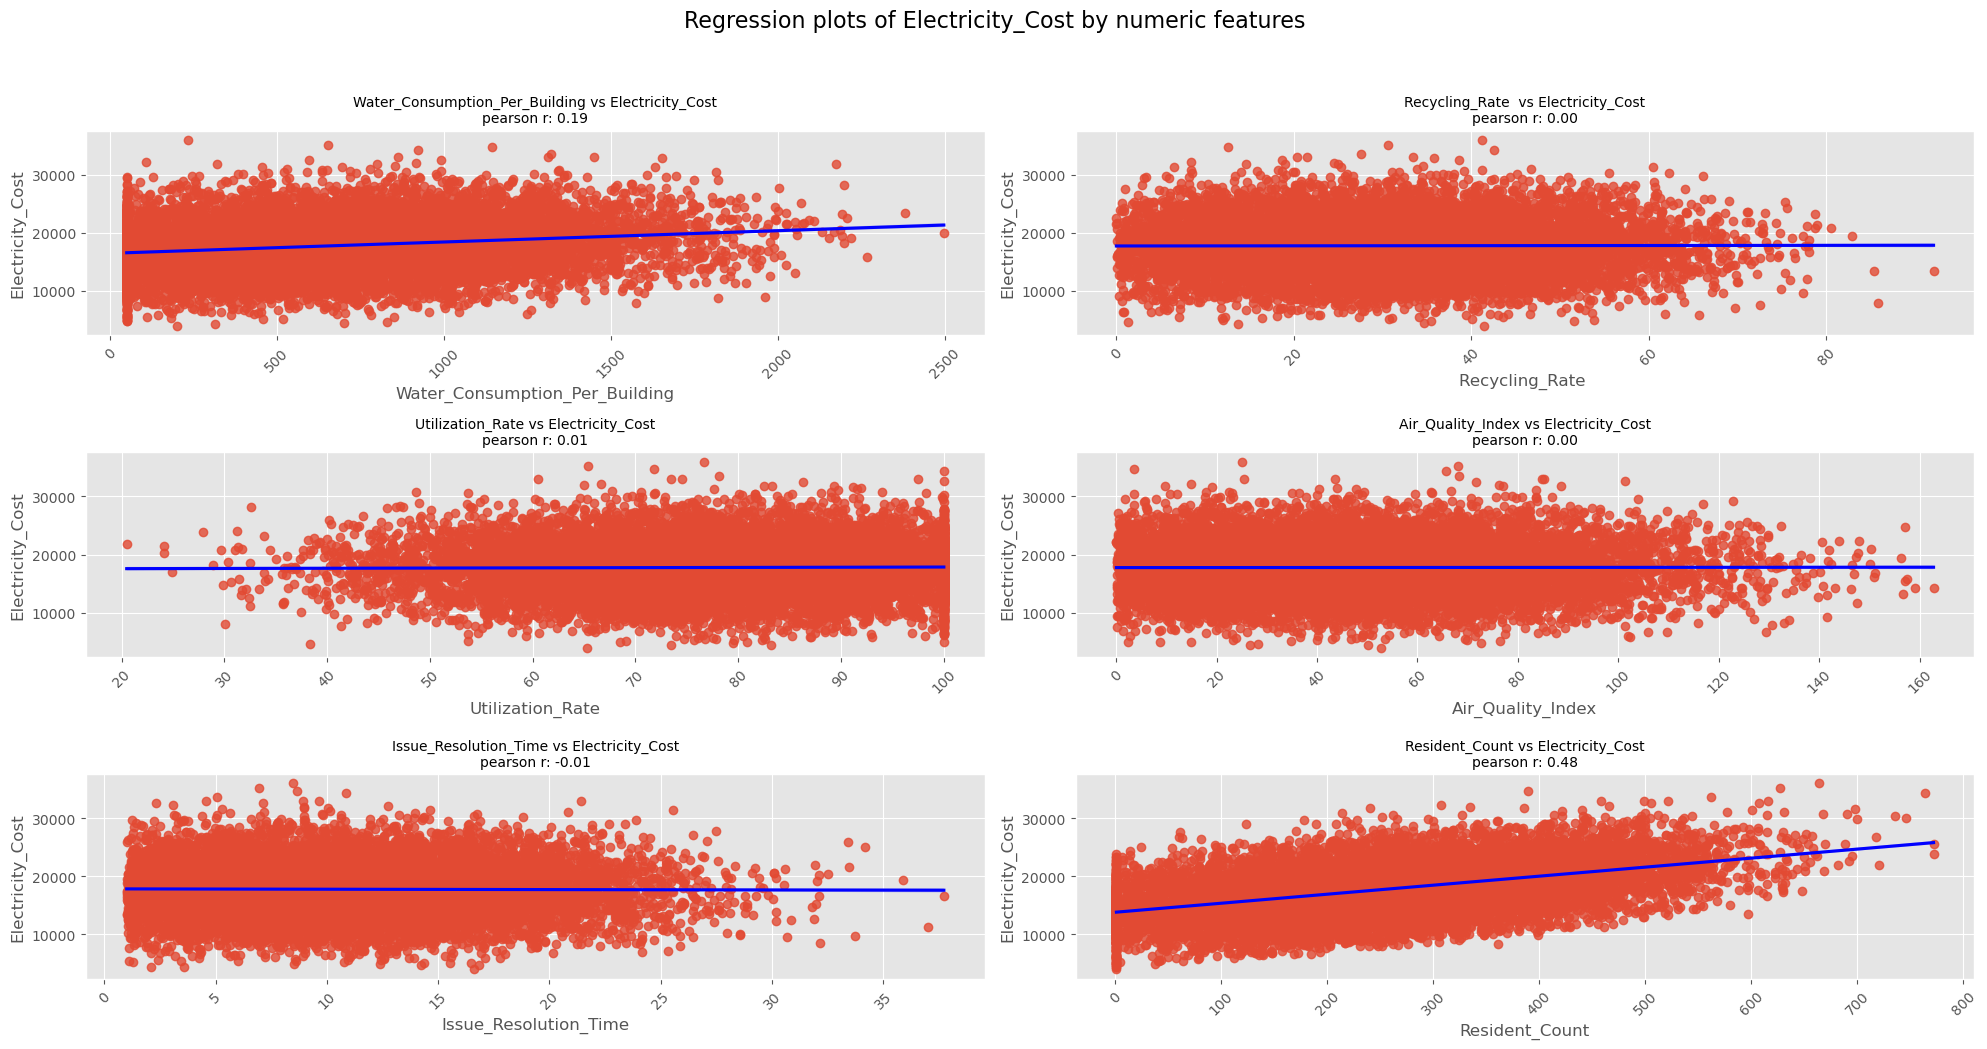

In [11]:
def reg_plot_label(num, train):
    length = len(num)
    cols = 2
    rows = length // cols + (length % cols > 0)

    plt.figure(figsize = (20, rows*cols+5))
    plt.suptitle(f'Regression plots of {LABEL} by numeric features', fontsize=16)
    for i, col in enumerate(num,1):
        plt.subplot(rows, cols, i)

        sns.regplot(x = col, y = LABEL, data = train, line_kws={'color':'blue'})

        plt.title(f"{col} vs {LABEL}\npearson r: {train[col].corr(train[LABEL]):.2f}", fontsize=10)

        plt.xlabel(col)
        plt.ylabel(LABEL)
        plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

reg_plot_label(numeric, train)

Most of numeric feature have not a linear relationship with the electricity cost.

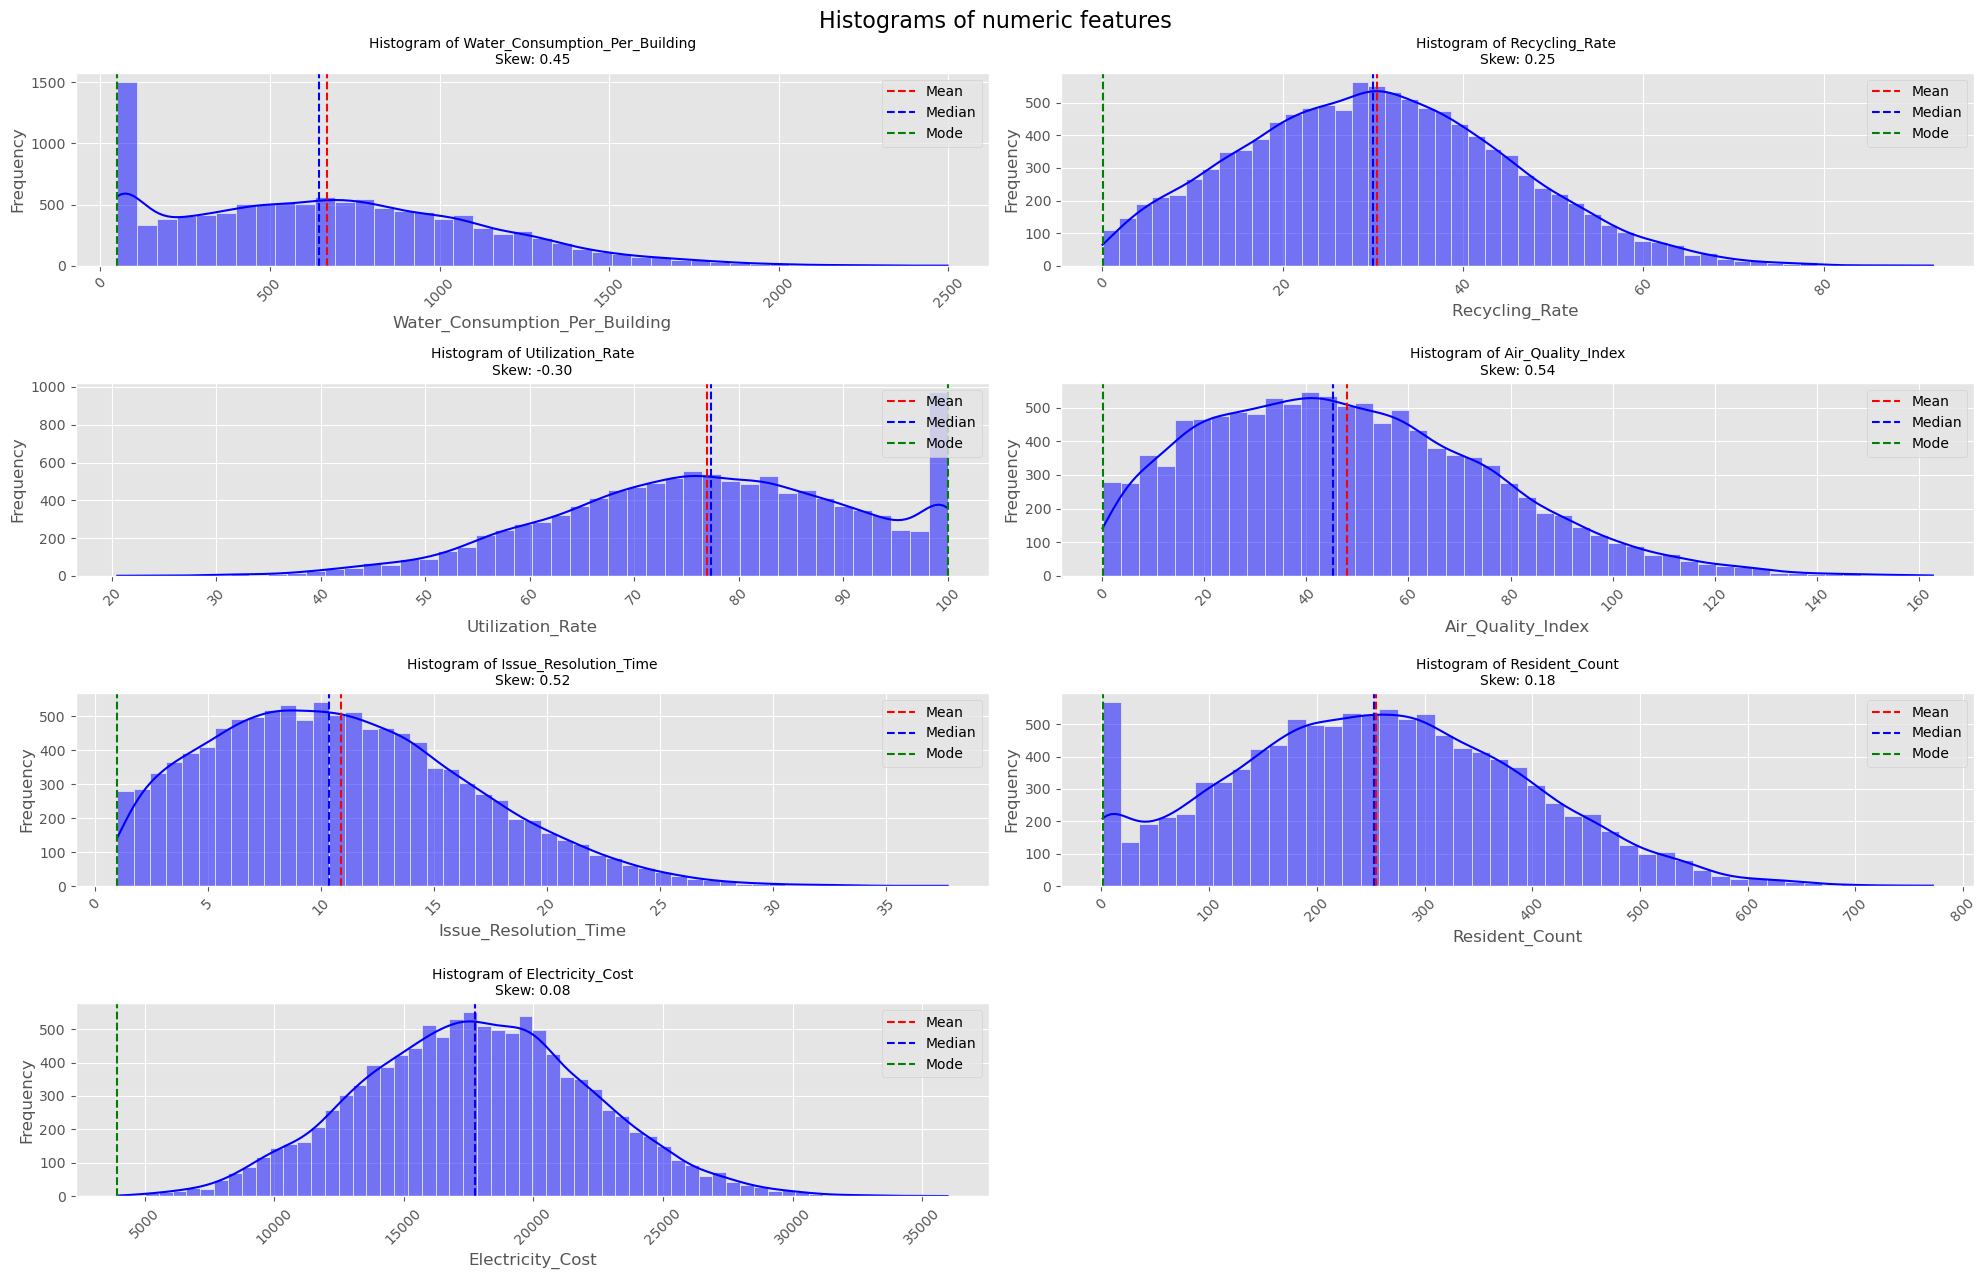

In [ ]:
def hist_plot(num):
    length = len(num)
    cols = 2
    rows = length // cols + (length % cols > 0)

    plt.figure(figsize = (20, rows*cols+5))
    plt.suptitle('Histograms of numeric features', fontsize=16)
    for i, col in enumerate(num,1):
        plt.subplot(rows, cols, i)

        sns.histplot(train[col], kde=True, color = 'b')

        plt.title(f"Histogram of {col}\nSkew: {skew(train[col]):.2f}", fontsize=10)
        plt.axvline(train[col].mean(), color='red', linestyle='--', label='Mean')
        plt.axvline(train[col].median(), color = 'blue', linestyle='--', label='Median')
        plt.axvline(train[col].mode()[0], color = 'green', linestyle='--', label='Mode')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

hist_plot(numeric)

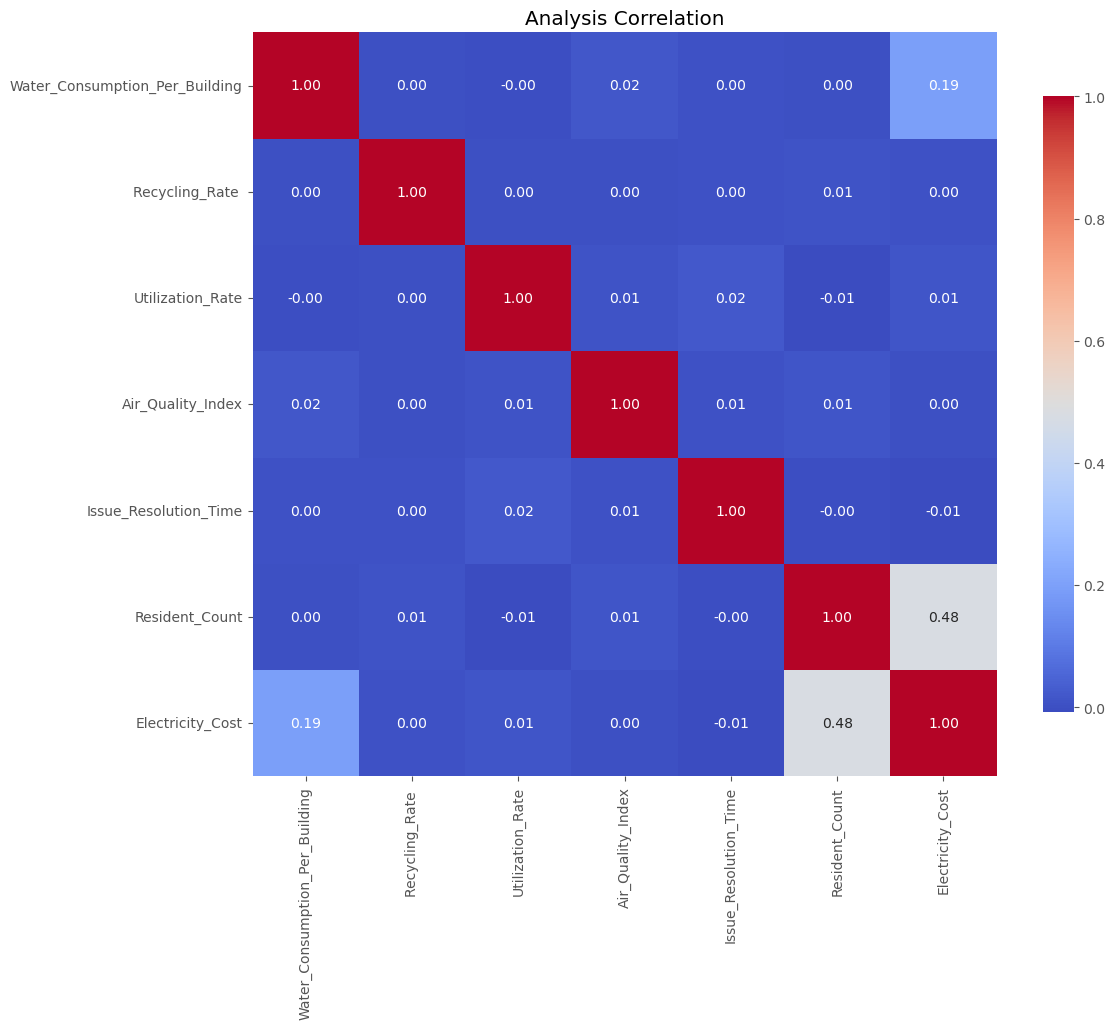

In [ ]:
corr = train[numeric].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Analysis Correlation")
plt.show()

In [57]:
train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

In [58]:
def add_features(df):
    df["Water_Per_Resident"] = df["Water_Consumption_Per_Building"] / df["Resident_Count"]
    high_residents = df["Resident_Count"] > df["Resident_Count"].quantile(0.75)
    water_above_mean = df["Water_Consumption_Per_Building"] > df["Water_Consumption_Per_Building"].mean()
    df["high_water_residents"] = (high_residents & water_above_mean).astype(int)
    low_air_quality = df["Air_Quality_Index"] < df["Air_Quality_Index"].quantile(0.25)
    issue_resolution_mean = df["Issue_Resolution_Time"].mean()
    df['low_air_high_issue'] = ((low_air_quality & (df["Issue_Resolution_Time"] > issue_resolution_mean)).astype(int))
    df['low_air_high_residents'] = ((low_air_quality & high_residents).astype(int))
    df['high_issue_residents'] = ((df["Issue_Resolution_Time"] > issue_resolution_mean) & high_residents).astype(int)
    high_recycling = df["Recycling_Rate"] > df["Recycling_Rate"].quantile(0.75)
    high_utilization = df["Utilization_Rate"] > df["Utilization_Rate"].quantile(0.75)
    df['high_recycling_utilization'] = ((high_recycling & high_utilization).astype(int))

    return df

train = add_features(train)
test = add_features(test)

In [14]:
(test.columns == train.columns).all()

True

In [59]:
X, y = train.drop(LABEL, axis = 1), train[LABEL]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test.drop(LABEL, axis = 1)

In [60]:
# Create transformer columns
numeric = [col for col in train.select_dtypes(include=['number']).columns if col != LABEL]
categoric = train.select_dtypes(include=['object']).columns

numeric_transformer = MinMaxScaler()
categoric_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categoric_transformer, categoric)
    ],
    remainder='passthrough'
)


X_train_preprocess = preprocessor.fit_transform(X_train)
X_val_preprocess = preprocessor.transform(X_val)
X_train_preprocess = pd.DataFrame(X_train_preprocess, columns = numeric + list(preprocessor.transformers_[1][1].get_feature_names_out(categoric)))
X_val_preprocess = pd.DataFrame(X_val_preprocess, columns = numeric + list(preprocessor.transformers_[1][1].get_feature_names_out(categoric)))
X_train_preprocess.shape, X_val_preprocess.shape

((8976, 25), (2244, 25))

In [29]:
X_train_preprocess.columns

Index(['Water_Consumption_Per_Building', 'Recycling_Rate', 'Utilization_Rate',
       'Air_Quality_Index', 'Issue_Resolution_Time', 'Resident_Count',
       'Water_Per_Resident', 'high_water_residents', 'low_air_high_issue',
       'low_air_high_residents', 'high_issue_residents',
       'high_recycling_utilization', 'Site_Area_Banashankari',
       'Site_Area_Electronic City', 'Site_Area_HSR Layout', 'Site_Area_Hebbal',
       'Site_Area_Indiranagar', 'Site_Area_Jayanagar', 'Site_Area_Koramangala',
       'Site_Area_Malleshwaram', 'Site_Area_Whitefield', 'Site_Area_Yelahanka',
       'Structure_Type_Industrial', 'Structure_Type_Institutional',
       'Structure_Type_Residential'],
      dtype='object')

In [30]:
processed = pd.read_csv('../data/processed/train_processed.csv')
processed.columns

Index(['Water_Consumption_Per_Building', 'Recycling_Rate', 'Utilization_Rate',
       'Air_Quality_Index', 'Issue_Resolution_Time', 'Resident_Count',
       'Water_Per_Resident', 'high_water_residents', 'low_air_high_issue',
       'low_air_high_residents', 'high_issue_residents',
       'high_recycling_utilization', 'Site_Area_Banashankari',
       'Site_Area_Electronic City', 'Site_Area_HSR Layout', 'Site_Area_Hebbal',
       'Site_Area_Indiranagar', 'Site_Area_Jayanagar', 'Site_Area_Koramangala',
       'Site_Area_Malleshwaram', 'Site_Area_Whitefield', 'Site_Area_Yelahanka',
       'Structure_Type_Industrial', 'Structure_Type_Institutional',
       'Structure_Type_Residential', 'Electricity_Cost'],
      dtype='object')

In [31]:
set(X_train_preprocess.columns) - set(processed.drop(LABEL, axis=1).columns)

set()

In [61]:
import pickle

with open('../artifacts/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [62]:
# Checkpoint (save processed data)

features = pd.concat([X_train_preprocess,X_val_preprocess], ignore_index=True)
labels = pd.concat([y_train, y_val], ignore_index=True)

train_processed = pd.concat([features, labels], axis=1).to_csv('../data/processed/train_processed.csv', index=False)
test_processed = pd.DataFrame(preprocessor.transform(X_test), columns = numeric + list(preprocessor.transformers_[1][1].get_feature_names_out(categoric))).to_csv('../data/processed/test_processed.csv', index=False)

In [63]:
models = {
    'rf': RandomForestRegressor(random_state=42),
    'gb': GradientBoostingRegressor(random_state=42),
    'xgb': XGBRegressor(random_state=42, verbose=0),
    'lgbm': LGBMRegressor(random_state=42, verbose = -1),
    'catboost': CatBoostRegressor(random_state=42, verbose=0)
}

In [18]:
def modelling(X_train, y_train, X_val, y_val, models):
    name_l, rmse_l, r2_l = [], [], []
    for name, model in models.items():
        print(f"Name: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        scores = cross_val_score(model, np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]), cv=KFold(n_splits=5), scoring='neg_root_mean_squared_error')
        print(f"RMSE: {rmse:.4f}\nR2: {r2:.4f}\nCV RMSE: {-scores.mean():.4f} (+/- {scores.std():.4f})")
        name_l.append(name)
        rmse_l.append(-scores.mean())
        r2_l.append(r2)
        print("-"*50)
    results = pd.DataFrame({'Model': name_l, 'RMSE': rmse_l, 'R2': r2_l})

    return results.sort_values(by='RMSE')

modelling(X_train_preprocess, y_train, X_val_preprocess, y_val, models)

Name: rf
RMSE: 4007.0511
R2: 0.2099
CV RMSE: 3935.0494 (+/- 50.9918)
--------------------------------------------------
Name: gb
RMSE: 3899.3983
R2: 0.2518
CV RMSE: 3845.0176 (+/- 37.2041)
--------------------------------------------------
Name: xgb
RMSE: 4156.7047
R2: 0.1498
CV RMSE: 4135.6157 (+/- 55.2233)
--------------------------------------------------
Name: lgbm
RMSE: 3964.0393
R2: 0.2268
CV RMSE: 3905.1238 (+/- 50.1522)
--------------------------------------------------
Name: catboost
RMSE: 3970.9771
R2: 0.2241
CV RMSE: 3921.7946 (+/- 48.6936)
--------------------------------------------------


,Model,RMSE,R2
1,gb,3845.017592,0.251829
3,lgbm,3905.123826,0.226819
4,catboost,3921.794587,0.224110
0,rf,3935.049360,0.209949
2,xgb,4135.615685,0.149834


In [ ]:
# Tunning on Gradient Boosting
def objective(trial, X_train_preprocess=X_train_preprocess, y_train=y_train, X_val_preprocess=X_val_preprocess, y_val=y_val):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000,10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 13),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    X_con, y_con = pd.concat([X_train_preprocess, X_val_preprocess]), pd.concat([y_train, y_val])
    for train_index, val_index in kf.split(X_con, y_con):
        X_train, X_val = X_con[train_index], X_con[val_index]
        y_train, y_val = y_con[train_index], y_con[val_index]
        model = GradientBoostingRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        scores.append(rmse)
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-07-06 15:39:20,282] A new study created in memory with name: no-name-f4d81450-c722-4037-8f52-b03602ccc6e3
[I 2025-07-06 15:41:36,319] Trial 0 finished with value: 3881.4037834813535 and parameters: {'n_estimators': 900, 'learning_rate': 0.02549895005026386, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.6222454718808841}. Best is trial 0 with value: 3881.4037834813535.
[I 2025-07-06 15:45:41,116] Trial 1 finished with value: 4144.854888032728 and parameters: {'n_estimators': 830, 'learning_rate': 0.0671019113720323, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.5031880653076113}. Best is trial 0 with value: 3881.4037834813535.
[I 2025-07-06 15:48:11,490] Trial 2 finished with value: 3859.2237286480877 and parameters: {'n_estimators': 720, 'learning_rate': 0.016939412947279648, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.8824691579718584}. Best is trial 2 with value: 3859.2237286480

Best parameters: {'n_estimators': 720, 'learning_rate': 0.016939412947279648, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.8824691579718584}
Best RMSE: 3859.2237286480877


In [64]:
gbparams = {'n_estimators': 720, 'learning_rate': 0.016939412947279648, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'subsample': 0.8824691579718584}
gb = GradientBoostingRegressor(**gbparams, random_state=42)

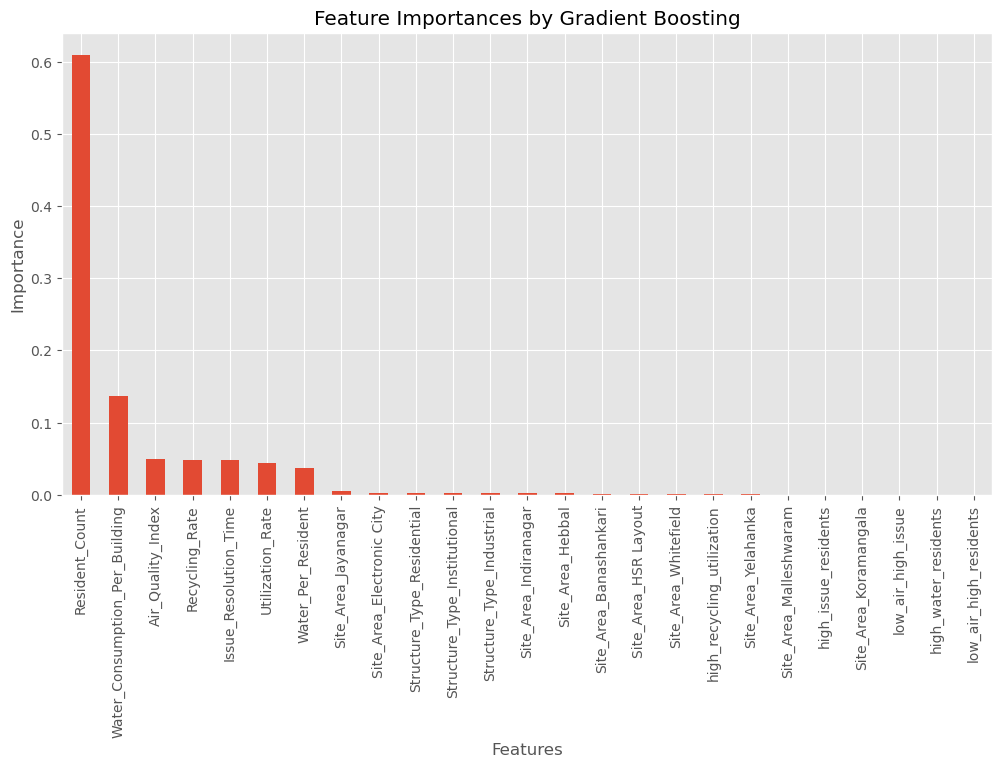

In [65]:
model = GradientBoostingRegressor(**gbparams, random_state=42)
model.fit(X_train_preprocess, y_train)
y_pred = model.predict(X_val_preprocess)

fe = model.feature_importances_
pd.Series(fe, index=X_train_preprocess.columns).sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importances by Gradient Boosting')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

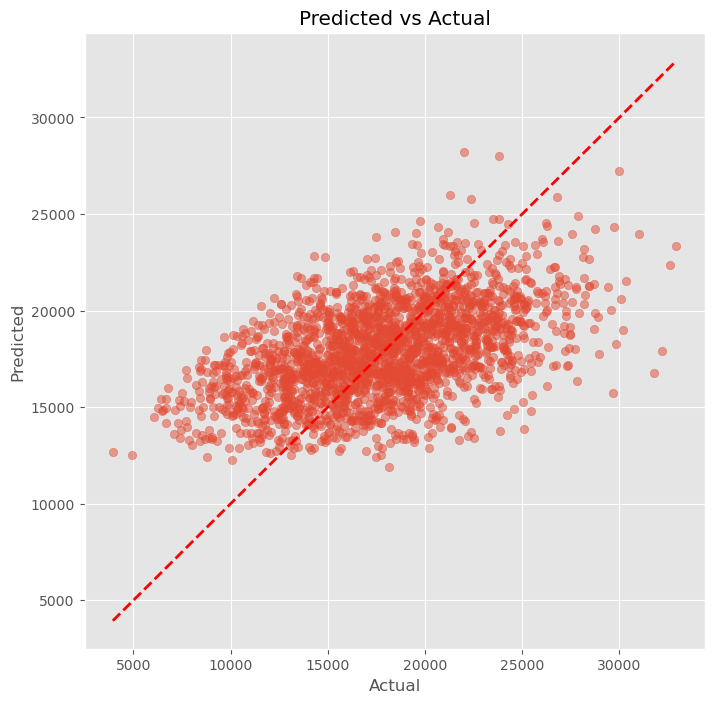

In [96]:
def plot_pred_actual(y_true, y_pred):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.show()

y_pred = model.predict(X_val_preprocess)
plot_pred_actual(y_val, y_pred)

In [66]:
with open('../artifacts/model.pkl', 'wb') as f:
    pickle.dump(model, f)

 97%|=================== | 2187/2244 [00:27<00:00]       

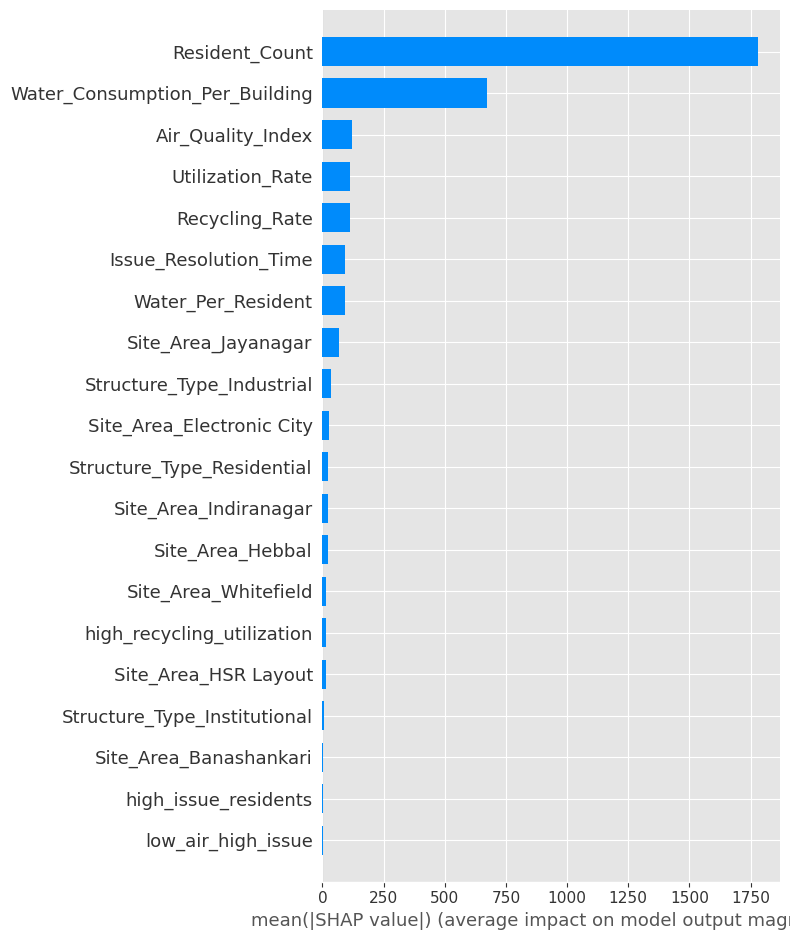

In [ ]:
# Visualize shap values
explainer = shap.Explainer(model, X_train_preprocess)
shap_values = explainer(X_val_preprocess)
shap.summary_plot(shap_values, X_val_preprocess, plot_type='bar')

In [67]:
X_train_preprocess.shape

(8976, 25)

In [50]:
X_test_preprocess = pd.DataFrame(preprocessor.transform(X_test), columns = numeric + list(preprocessor.transformers_[1][1].get_feature_names_out(categoric)))
y_pred = model.predict(X_test_preprocess)
submission[LABEL] = y_pred
submission

,Electricity_Cost
0,17415.611124
1,20976.039232
2,15572.679097
3,17525.064729
4,19737.931966
...,...
295,17234.471081
296,16642.817675
297,16721.271928
298,16748.667994


In [77]:
submission[LABEL].describe()

count      300.000000
mean     17637.222113
std       2429.540336
min      12170.795966
25%      15913.538284
50%      17398.597046
75%      19325.829300
max      24712.216904
Name: Electricity_Cost, dtype: float64

In [16]:
submission.to_csv('../submission/submission_final.csv', index=False)

In [84]:
sample = X_test.iloc[0]
sample

Site_Area                         Whitefield
Structure_Type                    Industrial
Water_Consumption_Per_Building    719.630788
Recycling_Rate                     27.476868
Utilization_Rate                   99.951059
Air_Quality_Index                  56.119189
Issue_Resolution_Time               2.039493
Resident_Count                           240
Water_Per_Resident                  2.998462
high_water_residents                       0
low_air_high_issue                         0
low_air_high_residents                     0
high_issue_residents                       0
high_recycling_utilization                 0
Name: 0, dtype: object

In [85]:
type(sample)

pandas.core.series.Series

In [95]:
numeric

['Water_Consumption_Per_Building',
 'Recycling_Rate',
 'Utilization_Rate',
 'Air_Quality_Index',
 'Issue_Resolution_Time',
 'Resident_Count',
 'Water_Per_Resident']

In [91]:
X_test['Site_Area'].unique()

array(['Whitefield', 'Jayanagar', 'Indiranagar', 'HSR Layout',
       'Yelahanka', 'Electronic City', 'Malleshwaram', 'BTM Layout',
       'Banashankari', 'Koramangala', 'Hebbal'], dtype=object)

In [ ]:
preprocessor.transformers_[1][1].

('cat',
 OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
 Index(['Site_Area', 'Structure_Type'], dtype='object'))

In [ ]:
with open('../artifacts/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

with open('../artifacts/model.pkl', 'rb') as f:
    model = pickle.load(f)

numeric = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric = X_test.select_dtypes(include=['object']).columns.tolist()

sample_preprocess = pd.DataFrame(preprocessor.transform(pd.DataFrame([sample])), columns = numeric + list(preprocessor.transformers_[1][1].get_feature_names_out(categoric)))
y_pred = model.predict(sample_preprocess)
y_pred

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cat__Site_Area_Banashankari
- cat__Site_Area_Electronic City
- cat__Site_Area_HSR Layout
- cat__Site_Area_Hebbal
- cat__Site_Area_Indiranagar
- ...
Feature names seen at fit time, yet now missing:
- Air_Quality_Index
- Issue_Resolution_Time
- Recycling_Rate
- Resident_Count
- Site_Area_Banashankari
- ...
